<h1>Esto es para Eitan</h1>

usar nbdime para hacer merges en el codigo con github

<h2>Fase 1: Business Understanding</h2>



El banco Monopoly lleva muchos años atendiendo a sus clientes en Chile y recientemente ha sido adquirido por un Banco con capitales extranjeros llamado “Dormammu”. Dormammu nos ha encargado hacer estudios sobre los clientes del banco Monopoly, para conocer su comportamiento y detectar patrones. Además, debemos analizar cómo será su estrategia para abordar estos nuevos clientes dado el uso que ellos hacen de sus productos financieros.

Nosotros vamos a analizar su base de datos, limpiarla, seleccionar las variables que sirvan para alguna interpretación y entregar la mayor información posible a los dueños de este banco para que puedan conocer a los clientes, preparar una estrategia y abordar a este nuevo mercado.

Nuestro objetivo será ver si sus clientes pagan sus cuentas al día.
Para nuesstro modelo de clasificación utilizaremos la variable Paga_al_dia
Para nuuestro modelo de regresión utilizaremos Tota_monto_pagado


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.feature_selection import SelectKBest, f_classif

#%matplotlib inline

In [ ]:
#Link de Base de datos https://docs.google.com/spreadsheets/d/1fq30bn_G8wN4vyAvLOjFcYi0yYZft3PC/edit?usp=sharing&ouid=112329233676406678155&rtpof=true&sd=true

In [2]:
MONOPOLY_XLSX ='Base_clientes_Monopoly.xlsx'
MONOPOLY_CSV ='Base_clientes_Monopoly_otro.csv'

In [3]:
try:
    import common
    DATA = common.dataDirectory()
except ImportError:
    DATA = Path().resolve() / 'data'

In [4]:
df = pd.read_excel(MONOPOLY_XLSX)
df.head(10)

,Id,Subsegmento,Sexo,Region,Edad,Renta,Antiguedad,Internauta,Adicional,Dualidad,...,ColMx_T01,PagoNac_T01,PagoInt_T01,EeccNac_T01,EeccInt_T01,UsoL1_T01,UsoL2_T01,UsoLI_T01,IndRev_T01,target
0,1,160,M,13.0,43,NaN,130,1,1,0,...,0.0,33000,0.0,1099866.0,0.0,1099866.0,15080,0.0,R,0
1,2,160,H,13.0,46,143640.0,69,1,0,0,...,0.0,300000,0.0,214592.0,0.0,214592.0,83596,0.0,R,0
2,3,170,H,13.0,45,929106.0,24,1,1,0,...,0.0,216676,0.0,0.0,0.0,7400.0,0,0.0,T,0
3,4,151,H,13.0,46,172447.0,134,0,1,0,...,0.0,60000,0.0,272762.0,0.0,272762.0,10591,0.0,R,0
4,5,170,H,13.0,46,805250.0,116,0,1,1,...,0.0,272925,0.0,249562.0,0.0,75339.0,377782,0.0,R,0
5,6,170,H,13.0,47,707664.0,67,1,1,0,...,0.0,35800,0.0,35800.0,0.0,0.0,51197,0.0,R,0
6,7,811,H,13.0,48,1022833.0,21,1,0,1,...,0.0,9391,0.0,8818.0,0.0,8818.0,0,0.0,T,0
7,8,170,H,13.0,46,NaN,69,0,1,1,...,0.0,6000,0.0,283520.0,0.0,283520.0,0,0.0,R,0
8,9,170,H,13.0,49,1171066.0,33,0,0,0,...,0.0,60000,0.0,507629.0,0.0,507629.0,0,0.0,R,1
9,10,170,M,13.0,44,964387.0,23,1,1,0,...,0.0,92583,0.0,65487.0,0.0,65487.0,12084,0.0,R,0


<h2>Fase 2: Data Understanding</h2>


### Variables elegidas


- Region ______________________________| Región de Residencia
- Renta _______________________________| Renta del cliente
- Edad ________________________________| Edad del cliente
- Sexo ________________________________| Sexo del cliente
- Adicional ___________________________| Indicador de Tenecia de TC adicionales
- Consumo _____________________________| Indicador de Crédito de Consumo
- Cuentas _____________________________| Número de cuentas que tiene el cliente
- Monoproducto ________________________| Indicador de si el cliente es solo poseedor de una TC
- TC __________________________________| Número de Tarjeta de crédito que tiene el cliente
- Internauta___________________________| Indicador de cliente Internauta que usa la web Monopoly
- Dualidad ____________________________| Indicador de Dualidad (Cliente es dual si tiene 2 o mas TC)
- CUPO_L1 _____________________________| Cupo de la tarjeta crédito para compras nacionales
- CUPO_MX _____________________________| Cupo de la tarjeta crédito para compras internacionales
- FlgActCOL_T12 _______________________| Indicador de actividad en avances en cuotas con tasa en el mes X en la TC
- Txs_T12 _____________________________| Número de transacciones realizados por el cliente en TC en el mes X
- (Eliminada) FacCCOT_T12______________| Monto facturado en compras en cuotas con tasa por el cliente en TC en el mes X
- FacCI_T12 ___________________________| Monto facturado en compras internacionales por el cliente en TC en el mes X
- FacCN_T12 ___________________________| Monto facturado en compras nacionales por el cliente en TC en el mes X
- PagoInt_T12 _________________________| Monto de pagos de deuda internacional del cliente en el mes X
- PagoNac_T12 _________________________| Monto de pagos de deuda nacional del cliente en el mes X



Hipotecario

UsoL1_T12
UsoL2_T12
UsoLI_T12

### Variable creada

- Total_Facturas ______________________| Suma de facturas nacionales e internacionales de todo el año.
- Total_de_Transacciones ______________| Total de transacciones realizadas
- Total_Deuda_Pagada __________________| Suma de pagos de deudas nacionales e internacionales de todo el año.
- Paga_al_dia _________________________| Indicador si el cliente esta al dia con sus pagos al final del año.

Las variables region, edad y sexo fueron elegidas porque nos permiten segmentar a los clientes en base a características demográficas fundamentales.
Las variables renta, consumo, cuentas, monoproducto, TC, internauta y dualidad fueron elegidas porque nos permiten analizar el comportamiento financiero de los clientes.
Las variables CUPO_L1, CUPO_MX, FlgActCOL_TX, Txs_TX y FacCCOT_TX fueron elegidas porque nos permiten evaluar el riesgo de crédito y el uso de los productos de crédito

En resumen, la selección de estas variables se basa en la idea de que, para analizar bien el comportamiento de los clientes de tarjetas de crédito, es importante considerar tanto aspectos demográficos y socioeconómicos como el uso que le dan a la tarjeta. Al combinar estos datos, se puede tener una mejor visión del cliente y crear estrategias de marketing y abordar este mercado de mejor manera.

### Targets elegidos:

- El target elegido para el modelo de regresión es la variable creada llamada “Total_Deuda_Pagada” en la cual sumamos todos los pagos de sus deudas de sus compras nacionales e internacionales de los clientes.
- El target elegido para el modelo de clasificación es la variable "Paga_al_dia" , ya que queremos ver si el cliente paga o no paga sus deudas al finalizar el año.

In [236]:
df_monopoly = (df[['Region', 'Renta', 'Edad','Sexo', 'Adicional','Consumo', 'Cuentas', 'Hipotecario', 'Monoproducto' , 'TC', 'Dualidad', 'CUPO_L1', 'CUPO_MX',
                    'FlgActCOL_T01', 'FlgActCOL_T02', 'FlgActCOL_T03', 'FlgActCOL_T04', 'FlgActCOL_T05', 'FlgActCOL_T06', 'FlgActCOL_T07', 'FlgActCOL_T08','FlgActCOL_T09' ,'FlgActCOL_T10', 'FlgActCOL_T11', 'FlgActCOL_T12',
                    'Txs_T01', 'Txs_T02', 'Txs_T03', 'Txs_T04', 'Txs_T05', 'Txs_T06', 'Txs_T07', 'Txs_T08', 'Txs_T09', 'Txs_T10', 'Txs_T11', 'Txs_T12',
                    'UsoL1_T01','UsoL1_T02','UsoL1_T03','UsoL1_T04','UsoL1_T05','UsoL1_T06','UsoL1_T07','UsoL1_T08', 'UsoL1_T09', 'UsoL1_T10','UsoL1_T11','UsoL1_T12',
                    'UsoL2_T01','UsoL2_T02','UsoL2_T03','UsoL2_T04','UsoL2_T05','UsoL2_T06','UsoL2_T07','UsoL2_T08', 'UsoL2_T09', 'UsoL2_T10','UsoL2_T11','UsoL2_T12',
                    'UsoLI_T01','UsoLI_T02','UsoLI_T03','UsoLI_T04','UsoLI_T05','UsoLI_T06','UsoLI_T07','UsoLI_T08', 'UsoLI_T09', 'UsoLI_T10','UsoLI_T11','UsoLI_T12',
                    'FacCCOT_T01', 'FacCCOT_T02', 'FacCCOT_T03', 'FacCCOT_T04', 'FacCCOT_T05', 'FacCCOT_T06', 'FacCCOT_T07', 'FacCCOT_T08', 'FacCCOT_T09', 'FacCCOT_T10', 'FacCCOT_T11', 'FacCCOT_T12',
                    'FacCI_T01', 'FacCI_T02', 'FacCI_T03', 'FacCI_T04', 'FacCI_T05', 'FacCI_T06', 'FacCI_T07', 'FacCI_T08', 'FacCI_T09', 'FacCI_T10', 'FacCI_T11', 'FacCI_T12',
                    'FacCN_T01', 'FacCN_T02', 'FacCN_T03', 'FacCN_T04', 'FacCN_T05', 'FacCN_T06', 'FacCN_T07', 'FacCN_T08', 'FacCN_T09', 'FacCN_T10', 'FacCN_T11', 'FacCN_T12',
                    'PagoInt_T01', 'PagoInt_T02', 'PagoInt_T03', 'PagoInt_T04', 'PagoInt_T05', 'PagoInt_T06', 'PagoInt_T07', 'PagoInt_T08', 'PagoInt_T09', 'PagoInt_T10', 'PagoInt_T11', 'PagoInt_T12',
                    'PagoNac_T01', 'PagoNac_T02', 'PagoNac_T03', 'PagoNac_T04', 'PagoNac_T05', 'PagoNac_T06', 'PagoNac_T07', 'PagoNac_T08', 'PagoNac_T09', 'PagoNac_T10', 'PagoNac_T11', 'PagoNac_T12']])
df_monopoly

,Region,Renta,Edad,Sexo,Adicional,Consumo,Cuentas,Hipotecario,Monoproducto,TC,...,PagoNac_T03,PagoNac_T04,PagoNac_T05,PagoNac_T06,PagoNac_T07,PagoNac_T08,PagoNac_T09,PagoNac_T10,PagoNac_T11,PagoNac_T12
0,13.0,NaN,43,M,1,0,1,0,0,3,...,41000.0,39000.0,50000.0,36000.0,26000.0,25000.0,24000.0,23000.0,0.0,22000.0
1,13.0,143640.0,46,H,0,0,1,1,0,1,...,0.0,200000.0,200000.0,100000.0,200000.0,180000.0,221000.0,194000.0,150000.0,250000.0
2,13.0,929106.0,45,H,1,0,1,1,0,2,...,0.0,54138.0,69822.0,124289.0,60886.0,0.0,45890.0,14850.0,178179.0,29990.0
3,13.0,172447.0,46,H,1,0,1,0,1,2,...,60000.0,60000.0,50000.0,60000.0,45000.0,60000.0,60000.0,40000.0,50000.0,80000.0
4,13.0,805250.0,46,H,1,0,2,1,0,3,...,220811.0,246171.0,301860.0,386774.0,431776.0,435450.0,272969.0,301404.0,245513.0,236467.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51119,13.0,364978.0,51,H,1,0,2,0,0,3,...,0.0,83000.0,0.0,155000.0,80000.0,0.0,85000.0,80000.0,75000.0,50000.0
51120,13.0,625376.0,51,H,0,0,1,0,0,1,...,169661.0,76775.0,159171.0,346717.0,0.0,10336.0,45711.0,35454.0,37294.0,16358.0
51121,13.0,806220.0,47,H,1,0,1,0,0,2,...,26700.0,17283.0,13123.0,13092.0,0.0,0.0,110298.0,10000.0,20000.0,60000.0
51122,13.0,NaN,47,M,0,0,1,0,0,1,...,61173.0,18959.0,35158.0,46256.0,42031.0,47510.0,0.0,0.0,NaN,NaN


## Creacion de variables:

In [237]:
# Definiendo un umbral de pago (por ejemplo, 90% de las facturas)
df_monopoly['Total_Facturas'] =  df_monopoly[['FacCI_T12', 'FacCI_T11', 'FacCI_T10', 'FacCI_T09', 'FacCI_T08', 'FacCI_T07', 'FacCI_T06', 'FacCI_T05', 'FacCI_T04', 'FacCI_T03', 'FacCI_T02', 'FacCI_T01',
                                              'FacCN_T12', 'FacCN_T11', 'FacCN_T10', 'FacCN_T09', 'FacCN_T08', 'FacCN_T07', 'FacCN_T06', 'FacCN_T05', 'FacCN_T04', 'FacCN_T03', 'FacCN_T02', 'FacCN_T01']].sum(axis=1)


# Calculando la suma de pagos de los últimos 12 meses
df_monopoly['Total_Deuda_Pagada'] = df_monopoly[['PagoInt_T12', 'PagoInt_T11', 'PagoInt_T10', 'PagoInt_T09', 'PagoInt_T08', 'PagoInt_T07', 'PagoInt_T06', 'PagoInt_T05', 'PagoInt_T04', 'PagoInt_T03', 'PagoInt_T02', 'PagoInt_T01', 'PagoNac_T12', 'PagoNac_T11', 'PagoNac_T10', 'PagoNac_T09', 'PagoNac_T08', 'PagoNac_T07', 'PagoNac_T06', 'PagoNac_T05', 'PagoNac_T04', 'PagoNac_T03', 'PagoNac_T02', 'PagoNac_T01']].sum(axis=1)


df_monopoly['Total_de_Transacciones'] = df_monopoly[['Txs_T01', 'Txs_T02', 'Txs_T03', 'Txs_T04', 'Txs_T05', 'Txs_T06', 'Txs_T07', 'Txs_T08', 'Txs_T09', 'Txs_T10', 'Txs_T11', 'Txs_T12']].sum(axis=1)

df_monopoly['Total_Deuda_Compras'] = df_monopoly[['UsoL1_T01','UsoL1_T02','UsoL1_T03','UsoL1_T04','UsoL1_T05','UsoL1_T06','UsoL1_T07','UsoL1_T08', 'UsoL1_T09', 'UsoL1_T10','UsoL1_T11','UsoL1_T12']].sum(axis=1)
df_monopoly['Total_Deuda_Avances'] = df_monopoly[['UsoL2_T01','UsoL2_T02','UsoL2_T03','UsoL2_T04','UsoL2_T05','UsoL2_T06','UsoL2_T07','UsoL2_T08', 'UsoL2_T09', 'UsoL2_T10','UsoL2_T11','UsoL2_T12']].sum(axis=1)
df_monopoly['Total_Deuda_Internacional'] = df_monopoly[['UsoLI_T01','UsoLI_T02','UsoLI_T03','UsoLI_T04','UsoLI_T05','UsoLI_T06','UsoLI_T07','UsoLI_T08', 'UsoLI_T09', 'UsoLI_T10','UsoLI_T11','UsoLI_T12']].sum(axis=1)



df_monopoly['Paga_al_dia'] = df_monopoly['Total_Deuda_Pagada'] >= df_monopoly['Total_Facturas']
df_monopoly['Paga_al_dia'] = df_monopoly['Paga_al_dia'].astype(int)


#Otra manera de hacerlo como ayuda para futuro:

#df_monopoly['Paga_al_dia'] = 0
#df_monopoly.loc[df_monopoly['total_pago'] >= umbral, 'Paga_al_dia'] = 1

df_monopoly

C:\Users\Eitan\AppData\Local\Temp\ipykernel_16108\918854214.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_monopoly['Total_Facturas'] =  df_monopoly[['FacCI_T12', 'FacCI_T11', 'FacCI_T10', 'FacCI_T09', 'FacCI_T08', 'FacCI_T07', 'FacCI_T06', 'FacCI_T05', 'FacCI_T04', 'FacCI_T03', 'FacCI_T02', 'FacCI_T01',
C:\Users\Eitan\AppData\Local\Temp\ipykernel_16108\918854214.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_monopoly['Total_Deuda_Pagada'] = df_monopoly[['PagoInt_T12', 'PagoInt_T11', 'PagoIn

,Region,Renta,Edad,Sexo,Adicional,Consumo,Cuentas,Hipotecario,Monoproducto,TC,...,PagoNac_T10,PagoNac_T11,PagoNac_T12,Total_Facturas,Total_Deuda_Pagada,Total_de_Transacciones,Total_Deuda_Compras,Total_Deuda_Avances,Total_Deuda_Internacional,Paga_al_dia
0,13.0,NaN,43,M,1,0,1,0,0,3,...,23000.0,0.0,22000.0,3.862230e+05,352000.0,23.0,10956547.00,646491.0,0.0,0
1,13.0,143640.0,46,H,0,0,1,1,0,1,...,194000.0,150000.0,250000.0,1.355021e+06,2009000.0,44.0,5144818.00,1439567.0,1014.1,1
2,13.0,929106.0,45,H,1,0,1,1,0,2,...,14850.0,178179.0,29990.0,1.787789e+06,819909.0,60.0,303534.00,0.0,0.0,0
3,13.0,172447.0,46,H,1,0,1,0,1,2,...,40000.0,50000.0,80000.0,4.142860e+05,685000.0,25.0,4133010.00,381903.0,0.0,1
4,13.0,805250.0,46,H,1,0,2,1,0,3,...,301404.0,245513.0,236467.0,3.527268e+06,3495806.0,107.0,1006191.00,4831172.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51119,13.0,364978.0,51,H,1,0,2,0,0,3,...,80000.0,75000.0,50000.0,8.268950e+05,958000.0,78.0,7430102.00,441891.0,0.0,1
51120,13.0,625376.0,51,H,0,0,1,0,0,1,...,35454.0,37294.0,16358.0,1.384888e+06,1236737.0,21.0,34078.00,4128730.0,0.0,0
51121,13.0,806220.0,47,H,1,0,1,0,0,2,...,10000.0,20000.0,60000.0,1.691690e+05,304087.0,6.0,422642.00,188236.0,0.0,1
51122,13.0,NaN,47,M,0,0,1,0,0,1,...,0.0,NaN,NaN,4.027820e+05,303075.0,15.0,352213.00,84982.0,0.0,0


<h4>Limpiamos las variables que queremos utilizar:</h4>

In [238]:
#Tranformamos columna sexo a 2 columnas de Hombre y Mujer
#DEBERIA USAR ONE-HOT-ENCODING

df_monopoly['Hombre'] = (df_monopoly['Sexo'] == 'H').astype(int)
df_monopoly['Mujer'] = (df_monopoly['Sexo'] == 'M').astype(int)
df_monopoly.drop('Sexo', axis=1, inplace=True)

C:\Users\Eitan\AppData\Local\Temp\ipykernel_16108\834715158.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_monopoly['Hombre'] = (df_monopoly['Sexo'] == 'H').astype(int)
C:\Users\Eitan\AppData\Local\Temp\ipykernel_16108\834715158.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_monopoly['Mujer'] = (df_monopoly['Sexo'] == 'M').astype(int)
C:\Users\Eitan\AppData\Local\Temp\ipykernel_16108\834715158.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

S

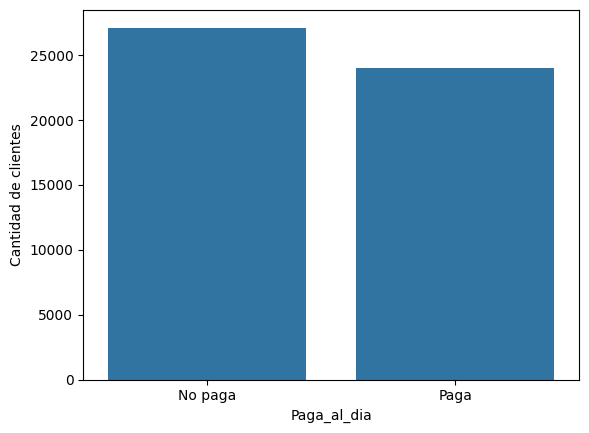

In [239]:
sns.countplot(x='Paga_al_dia', data=df_monopoly)
plt.xticks([0, 1], ['No paga', 'Paga'])
plt.ylabel('Cantidad de clientes')
plt.show()

In [188]:
df_graf = (df_monopoly[['Region','Renta','Edad','Hombre','Mujer','Adicional','Consumo','Cuentas', 'Hipotecario','Monoproducto','TC','Dualidad', 'Total_de_Transacciones','Total_Facturas','Total_Deuda_Pagada','Paga_al_dia']])

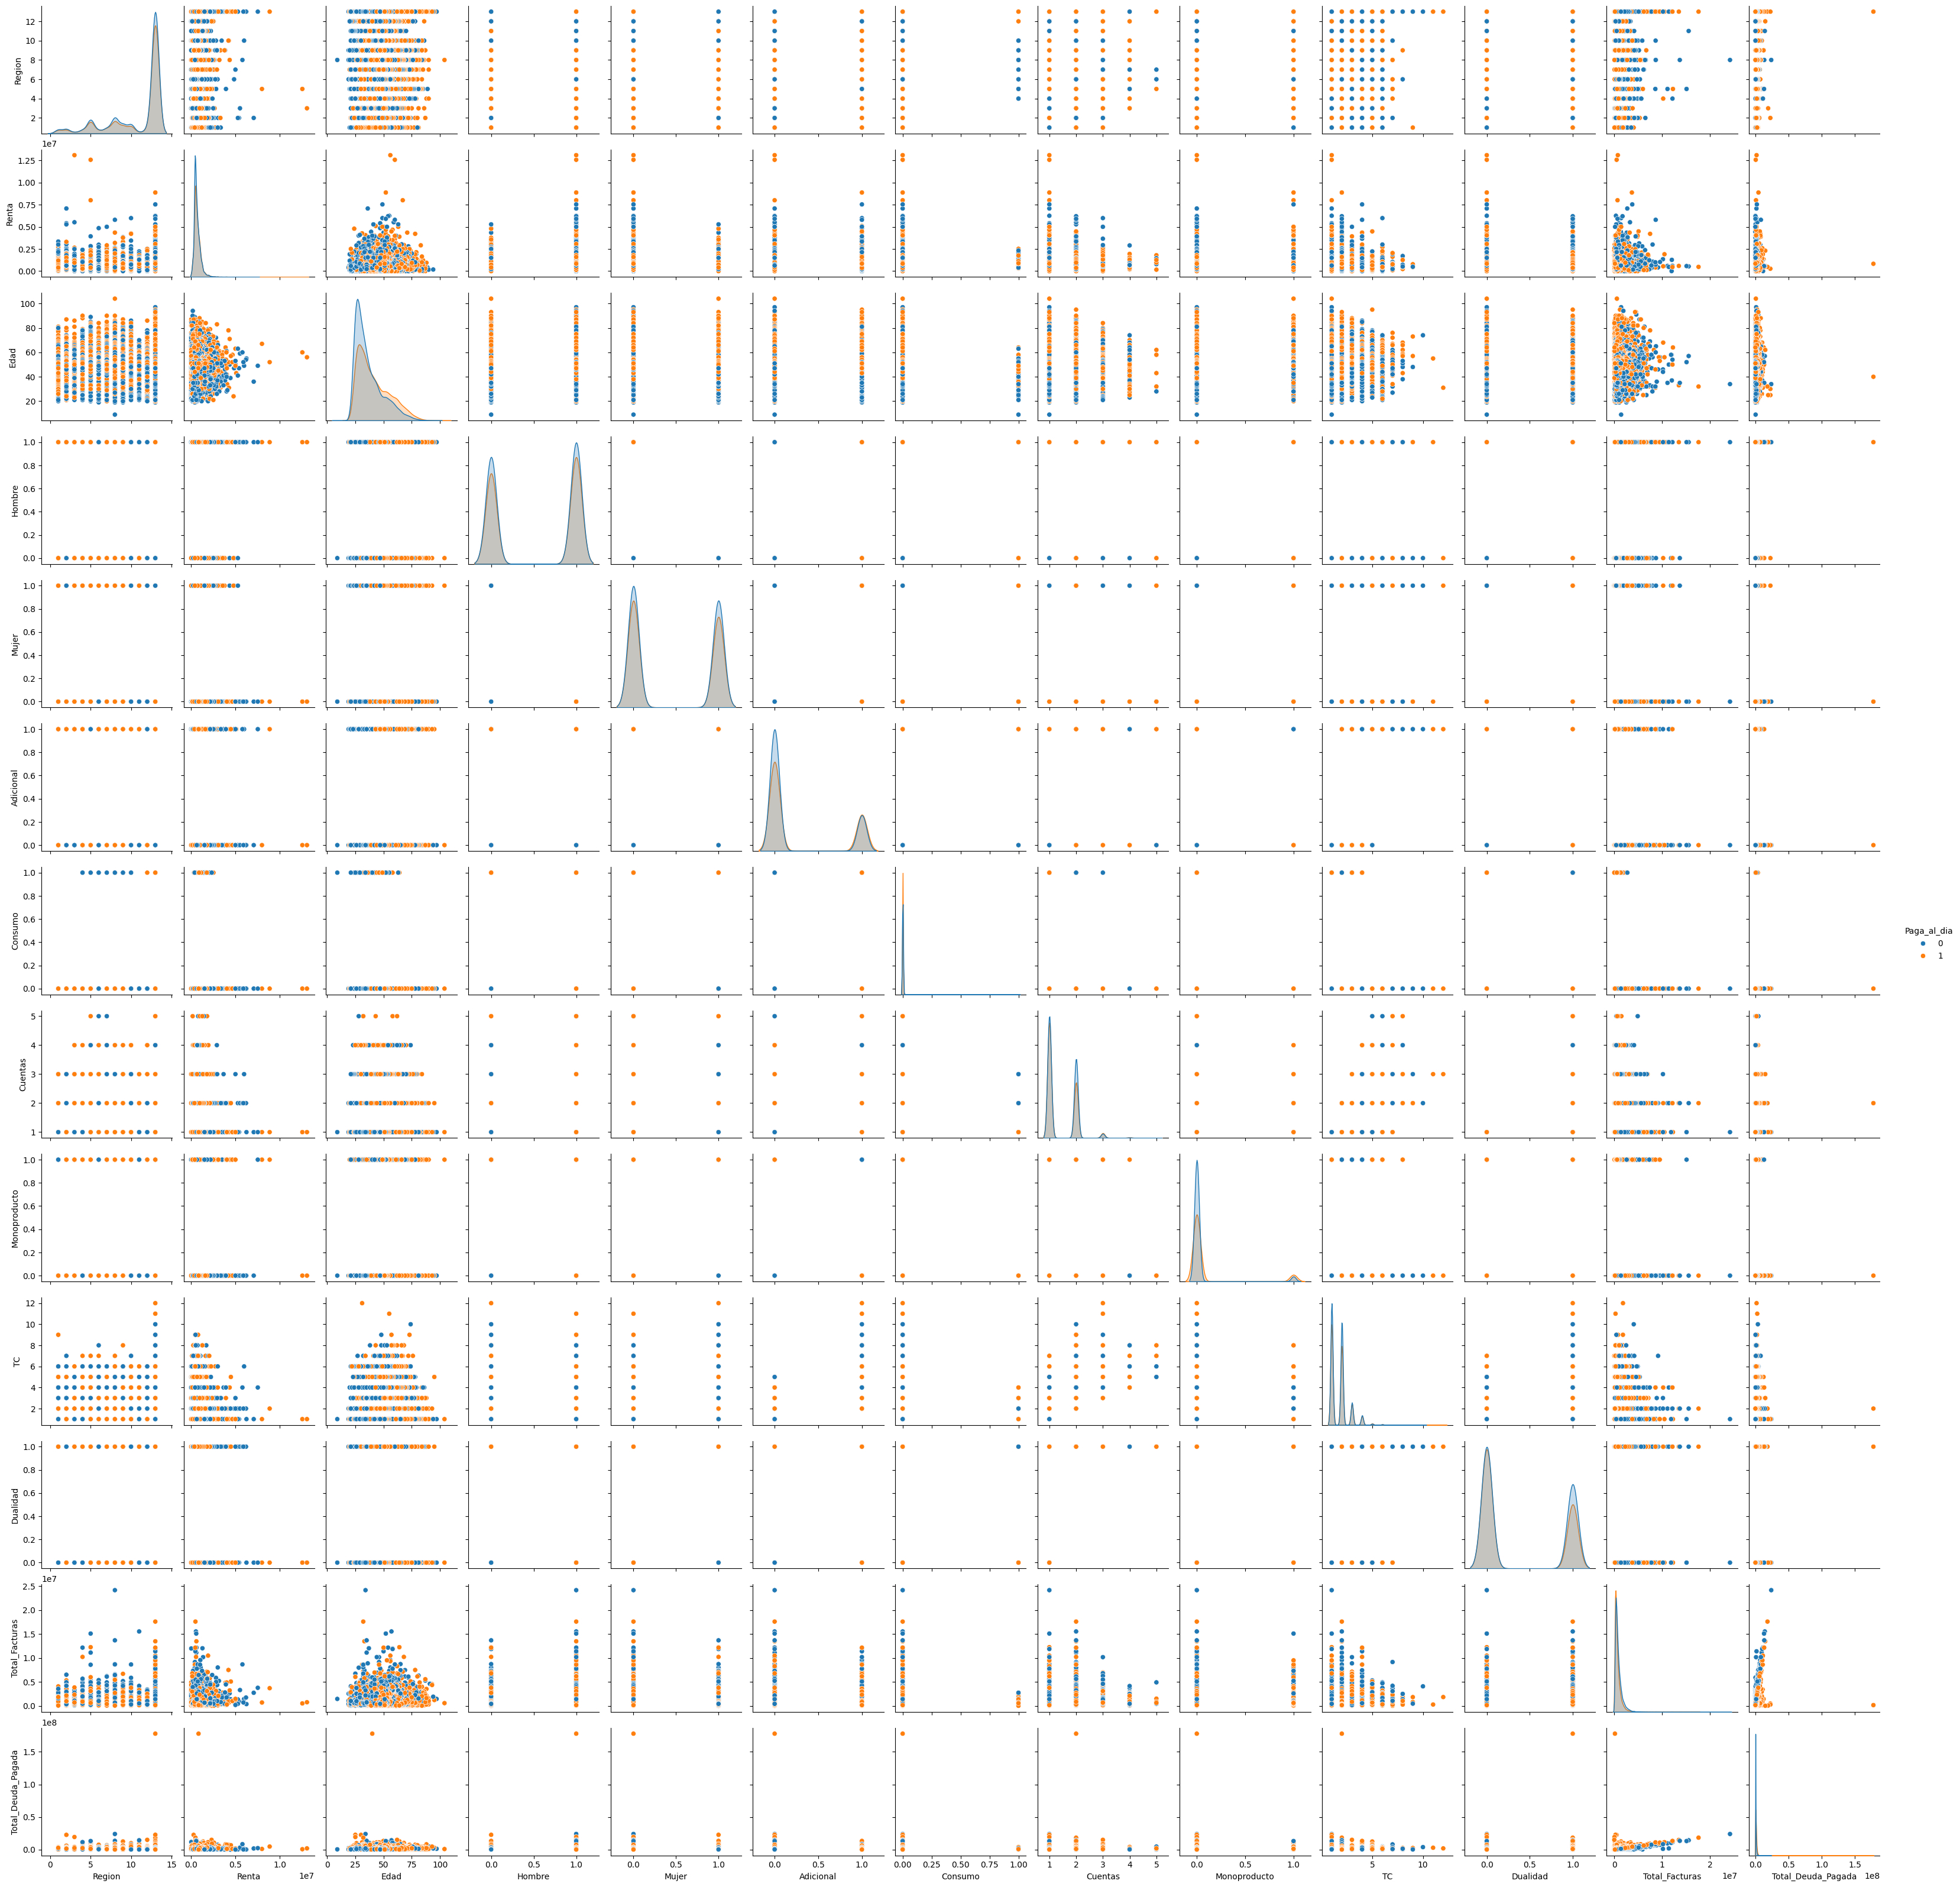

In [15]:
sns.pairplot(data=df_graf,hue='Paga_al_dia')

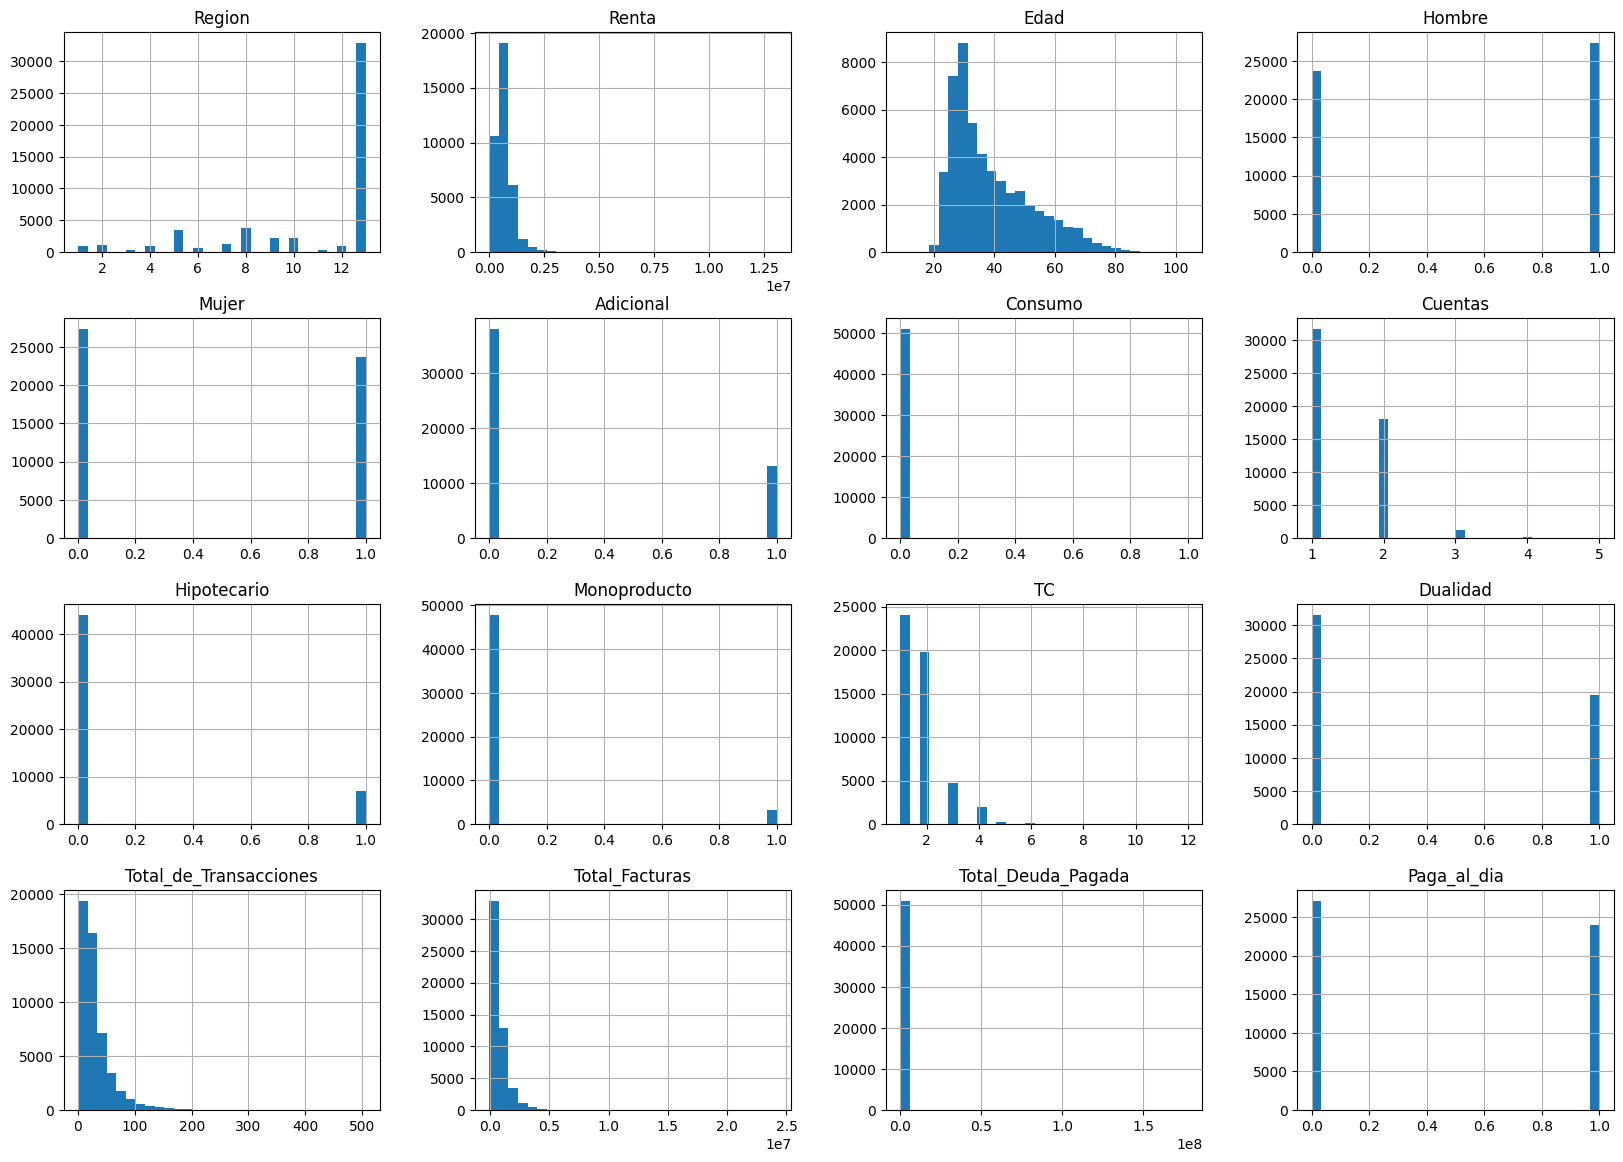

In [151]:
df_graf.hist(bins=30, figsize=(20, 14))
plt.show()

### Vemos la correlación entre variables

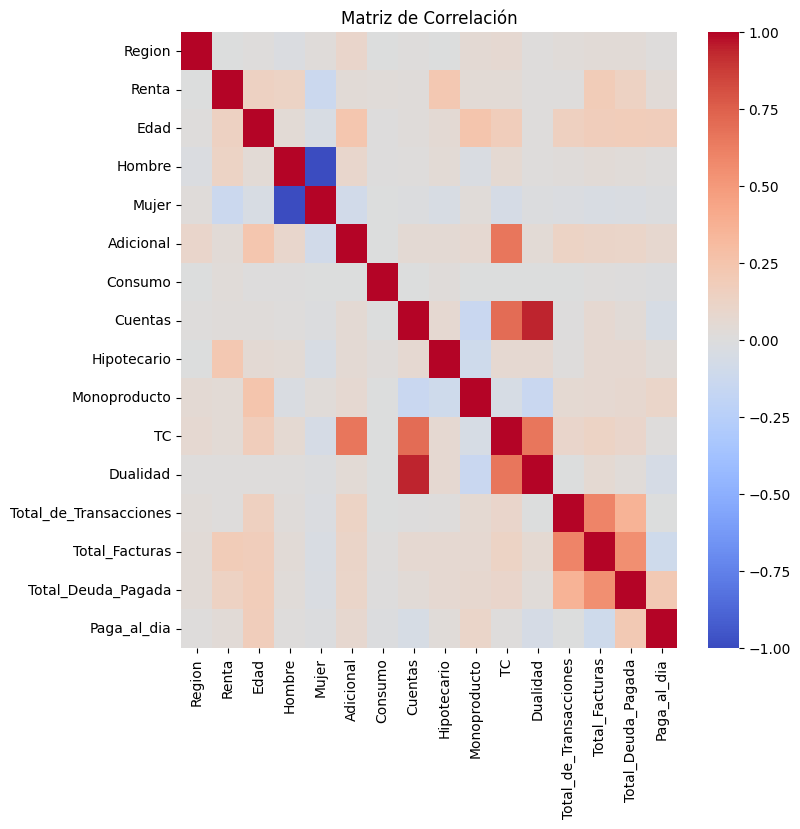

In [154]:
plt.figure(figsize=(8,8))

sns.heatmap(df_graf.corr(), vmin=-1, vmax=1, cmap='coolwarm')
plt.title('Matriz de Correlación')
plt.show()

## Manejo de nulos :

In [32]:
df_monopoly.isna().sum()

Region                   53
Renta                 13365
Edad                      0
Hombre                    0
Mujer                     0
                      ...  
PagoNac_T11            6632
PagoNac_T12            8251
Total_Deuda_Pagada        0
Total_Facturas            0
Paga_al_dia               0
Length: 101, dtype: int64

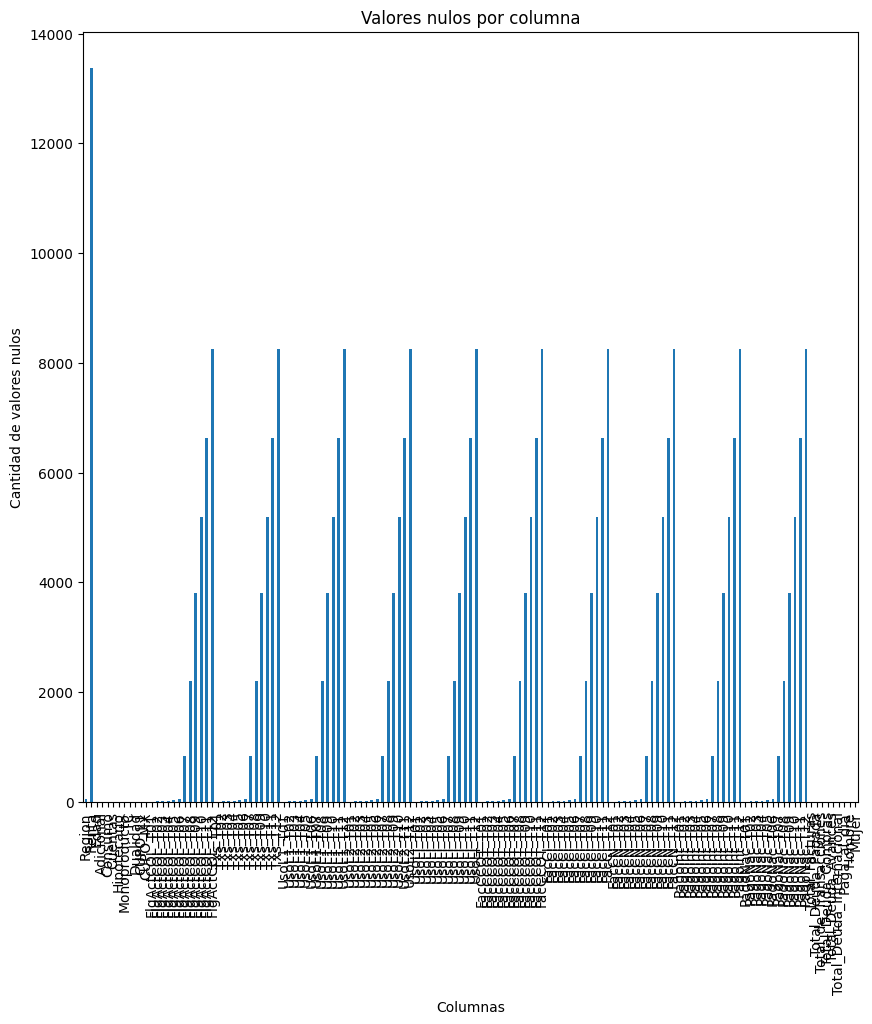

In [240]:
# Contar los valores nulos por columna
null_counts = df_monopoly.isnull().sum()

# Crear un gráfico de barras
plt.figure(figsize=(10, 10))
null_counts.plot(kind='bar')
plt.title('Valores nulos por columna')
plt.xlabel('Columnas')
plt.ylabel('Cantidad de valores nulos')
plt.show()

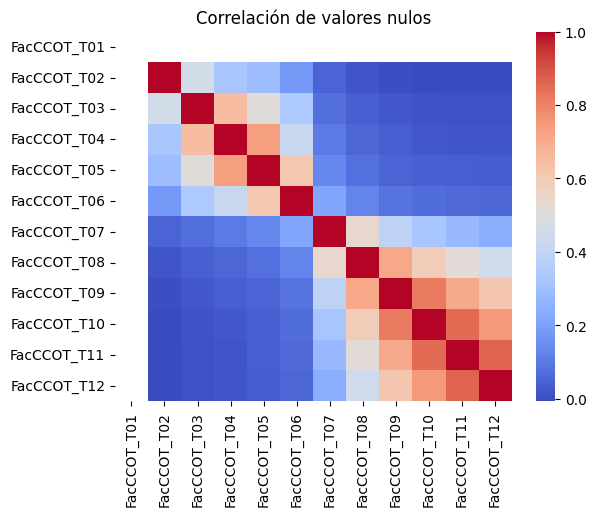

In [34]:
null_corr = df_monopoly[['FacCCOT_T01','FacCCOT_T02','FacCCOT_T03','FacCCOT_T04','FacCCOT_T05','FacCCOT_T06','FacCCOT_T07','FacCCOT_T08','FacCCOT_T09','FacCCOT_T10','FacCCOT_T11','FacCCOT_T12']].isnull().corr()

# Visualizar la matriz de correlación
sns.heatmap(null_corr, cmap='coolwarm')
plt.title('Correlación de valores nulos')
plt.show()

<h4>Imputar datos</h4>

A medida que analizamos los datos de los clientes a lo largo del tiempo, observamos que los valores nulos aumentaban en ciertos períodos, lo que puede ser atribuido a inconsistencias en la captura de datos o a periodos donde la información no fue registrada correctamente. Para evitar la pérdida de información valiosa y mantener la continuidad temporal de los datos, optamos por utilizar la interpolación lineal.

Respecto a la variable Renta se optó por imputar el valor mínimo de la renta para los casos en los que este dato faltaba. Esta decisión se basó al evaluar el riesgo crediticio de los clientes. Al asignar el valor mínimo, se garantiza que la capacidad de pago estimada no sea superior a la real, lo que reduce el riesgo de incumplimiento. 

Respecto a los nulos de las variables Sexo y Region simplemente se eliminaron sus filas debido a el minimo porcentaje que tenia de nulos siendo menor a 1%.

In [241]:
# Seleccionamos las columnas a interpolar y usamos un bucle
columns_to_interpolate = [
    'FlgActCOL_T01', 'FlgActCOL_T02', 'FlgActCOL_T03', 'FlgActCOL_T04', 'FlgActCOL_T05', 'FlgActCOL_T06', 'FlgActCOL_T07', 'FlgActCOL_T08', 'FlgActCOL_T09', 'FlgActCOL_T10', 'FlgActCOL_T11', 'FlgActCOL_T12',
    'Txs_T01', 'Txs_T02', 'Txs_T03', 'Txs_T04', 'Txs_T05', 'Txs_T06', 'Txs_T07', 'Txs_T08', 'Txs_T09', 'Txs_T10', 'Txs_T11', 'Txs_T12',
    'FacCCOT_T01', 'FacCCOT_T02', 'FacCCOT_T03', 'FacCCOT_T04', 'FacCCOT_T05', 'FacCCOT_T06', 'FacCCOT_T07', 'FacCCOT_T08', 'FacCCOT_T09', 'FacCCOT_T10', 'FacCCOT_T11', 'FacCCOT_T12',
    'FacCI_T01', 'FacCI_T02', 'FacCI_T03', 'FacCI_T04', 'FacCI_T05', 'FacCI_T06', 'FacCI_T07', 'FacCI_T08', 'FacCI_T09', 'FacCI_T10', 'FacCI_T11', 'FacCI_T12',
    'FacCN_T01', 'FacCN_T02', 'FacCN_T03', 'FacCN_T04', 'FacCN_T05', 'FacCN_T06', 'FacCN_T07', 'FacCN_T08', 'FacCN_T09', 'FacCN_T10', 'FacCN_T11', 'FacCN_T12',
    'PagoInt_T01', 'PagoInt_T02', 'PagoInt_T03', 'PagoInt_T04', 'PagoInt_T05', 'PagoInt_T06', 'PagoInt_T07', 'PagoInt_T08', 'PagoInt_T09', 'PagoInt_T10', 'PagoInt_T11', 'PagoInt_T12',
    'PagoNac_T01', 'PagoNac_T02', 'PagoNac_T03', 'PagoNac_T04', 'PagoNac_T05', 'PagoNac_T06', 'PagoNac_T07', 'PagoNac_T08', 'PagoNac_T09', 'PagoNac_T10', 'PagoNac_T11', 'PagoNac_T12',
    'UsoL1_T01','UsoL1_T02','UsoL1_T03','UsoL1_T04','UsoL1_T05','UsoL1_T06','UsoL1_T07','UsoL1_T08', 'UsoL1_T09', 'UsoL1_T10','UsoL1_T11','UsoL1_T12',
    'UsoL2_T01','UsoL2_T02','UsoL2_T03','UsoL2_T04','UsoL2_T05','UsoL2_T06','UsoL2_T07','UsoL2_T08', 'UsoL2_T09', 'UsoL2_T10','UsoL2_T11','UsoL2_T12',
    'UsoLI_T01','UsoLI_T02','UsoLI_T03','UsoLI_T04','UsoLI_T05','UsoLI_T06','UsoLI_T07','UsoLI_T08', 'UsoLI_T09', 'UsoLI_T10','UsoLI_T11','UsoLI_T12'
                    
]

# Iteramos sobre las columnas para aplicar la interpolación
for column in columns_to_interpolate:
    df_monopoly[column] = df_monopoly[column].interpolate(method='linear')

#Rellenamos Renta con el valor minimo
df_monopoly['Renta'].fillna(df_monopoly['Renta'].min(), inplace=True)

#Eliminamos filas nulas de Sexo y Region
df_monopoly = df_monopoly.dropna(subset=['Hombre', 'Mujer', 'Region'])

# Verificamos los resultados
print(df_monopoly[columns_to_interpolate].isnull().sum())


C:\Users\Eitan\AppData\Local\Temp\ipykernel_16108\4252327702.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_monopoly[column] = df_monopoly[column].interpolate(method='linear')


FlgActCOL_T01    0
FlgActCOL_T02    0
FlgActCOL_T03    0
FlgActCOL_T04    0
FlgActCOL_T05    0
                ..
UsoLI_T08        0
UsoLI_T09        0
UsoLI_T10        0
UsoLI_T11        0
UsoLI_T12        0
Length: 120, dtype: int64


C:\Users\Eitan\AppData\Local\Temp\ipykernel_16108\4252327702.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_monopoly['Renta'].fillna(df_monopoly['Renta'].min(), inplace=True)
C:\Users\Eitan\AppData\Local\Temp\ipykernel_16108\4252327702.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_monopoly['Renta'].fillna(df_monopoly['Renta'

In [37]:
df_monopoly.isna().sum()

Region                0
Renta                 0
Edad                  0
Hombre                0
Mujer                 0
                     ..
PagoNac_T11           0
PagoNac_T12           0
Total_Deuda_Pagada    0
Total_Facturas        0
Paga_al_dia           0
Length: 101, dtype: int64

Se actualizan las variables con los valores imputados

In [242]:
# Definiendo un umbral de pago (por ejemplo, 90% de las facturas)
df_monopoly['Total_Facturas'] =  df_monopoly[['FacCI_T12', 'FacCI_T11', 'FacCI_T10', 'FacCI_T09', 'FacCI_T08', 'FacCI_T07', 'FacCI_T06', 'FacCI_T05', 'FacCI_T04', 'FacCI_T03', 'FacCI_T02', 'FacCI_T01',
                                              'FacCN_T12', 'FacCN_T11', 'FacCN_T10', 'FacCN_T09', 'FacCN_T08', 'FacCN_T07', 'FacCN_T06', 'FacCN_T05', 'FacCN_T04', 'FacCN_T03', 'FacCN_T02', 'FacCN_T01']].sum(axis=1)


# Calculando la suma de pagos de los últimos 12 meses
df_monopoly['Total_Deuda_Pagada'] = df_monopoly[['PagoInt_T12', 'PagoInt_T11', 'PagoInt_T10', 'PagoInt_T09', 'PagoInt_T08', 'PagoInt_T07', 'PagoInt_T06', 'PagoInt_T05', 'PagoInt_T04', 'PagoInt_T03', 'PagoInt_T02', 'PagoInt_T01', 'PagoNac_T12', 'PagoNac_T11', 'PagoNac_T10', 'PagoNac_T09', 'PagoNac_T08', 'PagoNac_T07', 'PagoNac_T06', 'PagoNac_T05', 'PagoNac_T04', 'PagoNac_T03', 'PagoNac_T02', 'PagoNac_T01']].sum(axis=1)


df_monopoly['Total_de_Transacciones'] = df_monopoly[['Txs_T01', 'Txs_T02', 'Txs_T03', 'Txs_T04', 'Txs_T05', 'Txs_T06', 'Txs_T07', 'Txs_T08', 'Txs_T09', 'Txs_T10', 'Txs_T11', 'Txs_T12']].sum(axis=1)

df_monopoly['Total_Deuda_Compras'] = df_monopoly[['UsoL1_T01','UsoL1_T02','UsoL1_T03','UsoL1_T04','UsoL1_T05','UsoL1_T06','UsoL1_T07','UsoL1_T08', 'UsoL1_T09', 'UsoL1_T10','UsoL1_T11','UsoL1_T12']].sum(axis=1)
df_monopoly['Total_Deuda_Avances'] = df_monopoly[['UsoL2_T01','UsoL2_T02','UsoL2_T03','UsoL2_T04','UsoL2_T05','UsoL2_T06','UsoL2_T07','UsoL2_T08', 'UsoL2_T09', 'UsoL2_T10','UsoL2_T11','UsoL2_T12']].sum(axis=1)
df_monopoly['Total_Deuda_Internacional'] = df_monopoly[['UsoLI_T01','UsoLI_T02','UsoLI_T03','UsoLI_T04','UsoLI_T05','UsoLI_T06','UsoLI_T07','UsoLI_T08', 'UsoLI_T09', 'UsoLI_T10','UsoLI_T11','UsoLI_T12']].sum(axis=1)



df_monopoly['Paga_al_dia'] = df_monopoly['Total_Deuda_Pagada'] >= df_monopoly['Total_Facturas']
df_monopoly['Paga_al_dia'] = df_monopoly['Paga_al_dia'].astype(int)


#Otra manera de hacerlo como ayuda para futuro:

#df_monopoly['Paga_al_dia'] = 0
#df_monopoly.loc[df_monopoly['total_pago'] >= umbral, 'Paga_al_dia'] = 1

df_monopoly

C:\Users\Eitan\AppData\Local\Temp\ipykernel_16108\918854214.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_monopoly['Total_Facturas'] =  df_monopoly[['FacCI_T12', 'FacCI_T11', 'FacCI_T10', 'FacCI_T09', 'FacCI_T08', 'FacCI_T07', 'FacCI_T06', 'FacCI_T05', 'FacCI_T04', 'FacCI_T03', 'FacCI_T02', 'FacCI_T01',
C:\Users\Eitan\AppData\Local\Temp\ipykernel_16108\918854214.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_monopoly['Total_Deuda_Pagada'] = df_monopoly[['PagoInt_T12', 'PagoInt_T11', 'PagoIn

,Region,Renta,Edad,Adicional,Consumo,Cuentas,Hipotecario,Monoproducto,TC,Dualidad,...,PagoNac_T12,Total_Facturas,Total_Deuda_Pagada,Total_de_Transacciones,Total_Deuda_Compras,Total_Deuda_Avances,Total_Deuda_Internacional,Paga_al_dia,Hombre,Mujer
0,13.0,1.0,43,1,0,1,0,0,3,0,...,22000.0,3.862230e+05,352000.0,23.0,10956547.00,646491.0,0.0,0,0,1
1,13.0,143640.0,46,0,0,1,1,0,1,0,...,250000.0,1.355021e+06,2009000.0,44.0,5144818.00,1439567.0,1014.1,1,1,0
2,13.0,929106.0,45,1,0,1,1,0,2,0,...,29990.0,1.787789e+06,819909.0,60.0,303534.00,0.0,0.0,0,1,0
3,13.0,172447.0,46,1,0,1,0,1,2,0,...,80000.0,4.142860e+05,685000.0,25.0,4133010.00,381903.0,0.0,1,1,0
4,13.0,805250.0,46,1,0,2,1,0,3,1,...,236467.0,3.527268e+06,3495806.0,107.0,1006191.00,4831172.0,0.0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51119,13.0,364978.0,51,1,0,2,0,0,3,1,...,50000.0,8.268950e+05,958000.0,78.0,7430102.00,441891.0,0.0,1,1,0
51120,13.0,625376.0,51,0,0,1,0,0,1,0,...,16358.0,1.384888e+06,1236737.0,21.0,34078.00,4128730.0,0.0,0,1,0
51121,13.0,806220.0,47,1,0,1,0,0,2,0,...,60000.0,1.691690e+05,304087.0,6.0,422642.00,188236.0,0.0,1,1,0
51122,13.0,1.0,47,0,0,1,0,0,1,0,...,30000.0,4.724520e+05,379953.5,18.0,490064.50,98482.0,0.0,0,0,1


<h5>Dividimos en tipo de variables:</h5>

In [202]:
var_continuas = (df_monopoly[['Renta','CUPO_L1', 'CUPO_MX',
                            'FlgActCOL_T01', 'FlgActCOL_T02', 'FlgActCOL_T03', 'FlgActCOL_T04', 'FlgActCOL_T05', 'FlgActCOL_T06', 'FlgActCOL_T07', 'FlgActCOL_T08','FlgActCOL_T09' ,'FlgActCOL_T10', 'FlgActCOL_T11', 'FlgActCOL_T12',
                            'Total_Deuda_Pagada', 'Total_Facturas' ]])

var_discretas = (df_monopoly[['Region' ,'Edad', 'Cuentas', 'TC', 'Total_de_Transacciones']])

var_nominales = (df_monopoly[['Hombre', 'Mujer', 'Adicional', 'Consumo', 'Monoproducto', 'Dualidad', 'Paga_al_dia']])

var_ordinales = (df_monopoly[['Region']])

<h2>Fase 3: Data Preparation</h2>

<h5>Reorganizamos las variables:</h5>

In [247]:
df_monopoly = df_monopoly.reindex(columns=['Region', 'Renta', 'Edad','Hombre','Mujer', 'Adicional','Consumo', 'Cuentas', 'Hipotecario', 'Monoproducto' , 'TC', 'Dualidad', 'CUPO_L1', 'CUPO_MX',
                    'FlgActCOL_T01', 'FlgActCOL_T02', 'FlgActCOL_T03', 'FlgActCOL_T04', 'FlgActCOL_T05', 'FlgActCOL_T06', 'FlgActCOL_T07', 'FlgActCOL_T08','FlgActCOL_T09' ,'FlgActCOL_T10', 'FlgActCOL_T11', 'FlgActCOL_T12',
                    'Total_Deuda_Internacional','Total_Deuda_Avances','Total_Deuda_Compras','Total_de_Transacciones', 'Total_Deuda_Pagada', 'Total_Facturas', 'Paga_al_dia'])

<h4>Normalizamos y Estandarizamos las variables</h4>

In [263]:
df_monopoly_nor = df_monopoly.copy()

In [264]:
#Aqui limpiamos las variables:
for i in df_monopoly_nor.columns[:-2]:
    mean = df_monopoly_nor[i].mean()
    std = df_monopoly_nor[i].std()
    mini = df_monopoly_nor[i].min()
    maxi = df_monopoly_nor[i].max()

    if i not in ['Edad', 'Region', 'Cuentas', 'TC']:
        #Estandarizamos
        df_monopoly_nor[i] = df_monopoly_nor[i].apply(lambda x: (x - mean) / std)

    else:
        #Normalizamos
        df_monopoly_nor[i] = df_monopoly_nor[i].apply(lambda x: (x - mini) / (maxi - mini))

In [272]:
df_monopoly_nor

,Region,Renta,Edad,Hombre,Mujer,Adicional,Consumo,Cuentas,Hipotecario,Monoproducto,...,FlgActCOL_T10,FlgActCOL_T11,FlgActCOL_T12,Total_Deuda_Internacional,Total_Deuda_Avances,Total_Deuda_Compras,Total_de_Transacciones,Total_Deuda_Pagada,Total_Facturas,Paga_al_dia
0,1.0,-1.072578,0.357895,-1.075242,1.075284,1.703545,-0.030025,0.00,-0.399559,-0.259663,...,-0.051767,-0.056931,-0.058673,-0.189609,-0.209099,3.144185,-0.286308,-0.441634,3.862230e+05,0
1,1.0,-0.758152,0.389474,0.930005,-0.929968,-0.587000,-0.030025,0.00,2.502712,-0.259663,...,-0.051767,-0.056931,-0.058673,1.667887,-0.029626,1.111020,0.377048,0.963787,1.355021e+06,1
2,1.0,0.961236,0.378947,0.930005,-0.929968,1.703545,-0.030025,0.00,2.502712,-0.259663,...,-0.051767,-0.056931,-0.058673,-0.189609,-0.355399,-0.582646,0.882463,-0.044767,1.787789e+06,0
3,1.0,-0.695093,0.389474,0.930005,-0.929968,1.703545,-0.030025,0.00,-0.399559,3.851074,...,-0.051767,-0.056931,-0.058673,-0.189609,-0.268975,0.757051,-0.223131,-0.159193,4.142860e+05,1
4,1.0,0.690115,0.389474,0.930005,-0.929968,1.703545,-0.030025,0.25,2.502712,-0.259663,...,-0.051767,-0.056931,-0.058673,-0.189609,0.737890,-0.336829,2.367118,2.224855,3.527268e+06,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51119,1.0,-0.273642,0.442105,0.930005,-0.929968,1.703545,-0.030025,0.25,-0.399559,-0.259663,...,-0.051767,-0.056931,-0.058673,-0.189609,-0.255399,1.910500,1.451054,0.072358,8.268950e+05,1
51120,1.0,0.296370,0.442105,0.930005,-0.929968,-0.587000,-0.030025,0.00,-0.399559,-0.259663,...,-0.051767,-0.056931,-0.058673,-0.189609,0.578929,-0.676912,-0.349485,0.308775,1.384888e+06,0
51121,1.0,0.692238,0.400000,0.930005,-0.929968,1.703545,-0.030025,0.00,-0.399559,-0.259663,...,-0.051767,-0.056931,-0.058673,-0.189609,-0.312801,-0.540977,-0.823311,-0.482273,1.691690e+05,1
51122,1.0,-1.072578,0.400000,-1.075242,1.075284,-0.587000,-0.030025,0.00,-0.399559,-0.259663,...,-0.051767,-0.056931,-0.058673,-0.189609,-0.333112,-0.517390,-0.444250,-0.417925,4.724520e+05,0


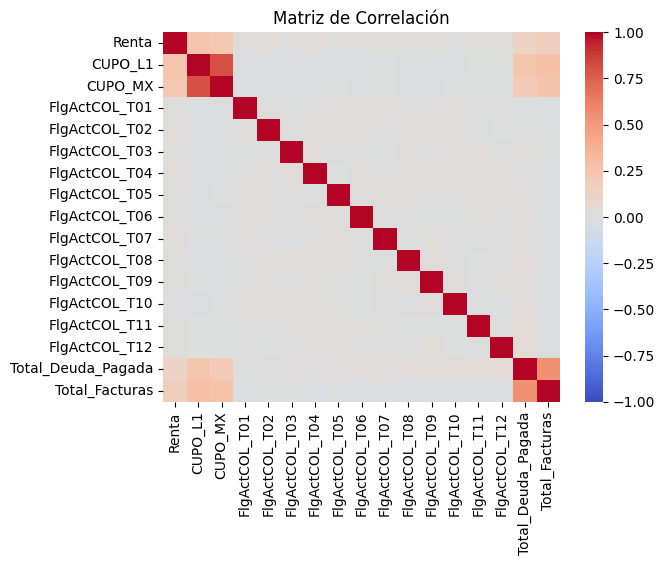

In [196]:
sns.heatmap(var_continuas.corr(), vmin=-1, vmax=1, cmap='coolwarm')
plt.title('Matriz de Correlación')
plt.show()

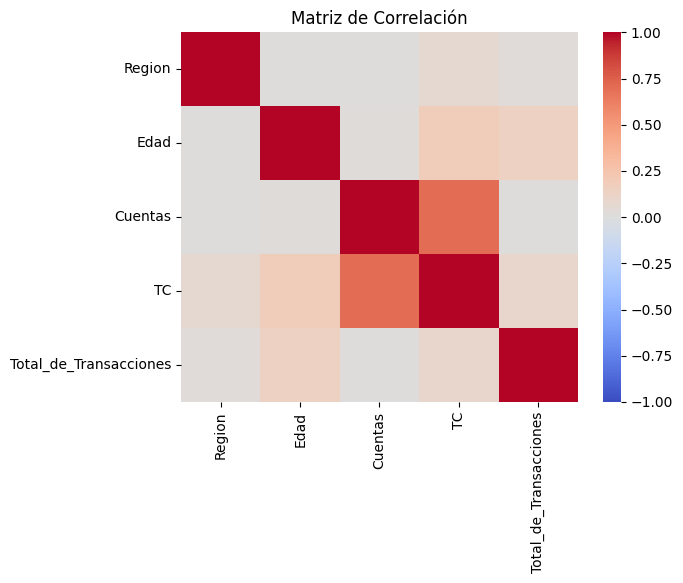

In [203]:
sns.heatmap(var_discretas.corr(), vmin=-1, vmax=1, cmap='coolwarm')
plt.title('Matriz de Correlación')
plt.show()

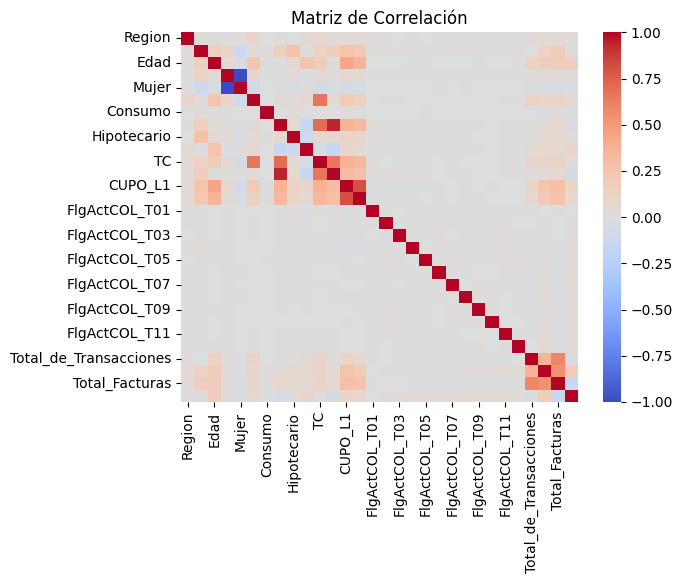

In [201]:
sns.heatmap(df_monopoly_nor.corr(), vmin=-1, vmax=1, cmap='coolwarm')
plt.title('Matriz de Correlación')
plt.show()

<h2>Fase 4: Modeling</h2>

<h3>Regresión</h3>

In [211]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [265]:
X = df_monopoly_nor[['Region', 'Renta', 'Edad','Hombre','Mujer', 'Adicional', 'Cuentas','Hipotecario','Monoproducto' , 'TC', 'CUPO_L1', 'CUPO_MX',
                    'FlgActCOL_T01', 'FlgActCOL_T02', 'FlgActCOL_T03', 'FlgActCOL_T04', 'FlgActCOL_T05', 'FlgActCOL_T06', 'FlgActCOL_T07', 'FlgActCOL_T08','FlgActCOL_T09' ,'FlgActCOL_T10', 'FlgActCOL_T11', 'FlgActCOL_T12',
                    'Total_Deuda_Compras','Total_Deuda_Internacional','Total_Deuda_Avances','Total_Facturas', 'Paga_al_dia']]
y = df_monopoly_nor['Total_Deuda_Pagada']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)


###### Regresion lineal:

In [266]:

# Crear y entrenar el modelo
model = LinearRegression()
model.fit(X_train, y_train)

# Hacer predicciones
y_pred_lin = model.predict(X_test)

# Evaluar el modelo
mae = mean_absolute_error(y_test, y_pred_lin)
mse = mean_squared_error(y_test, y_pred_lin)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_lin)
print('R-squared:', r2)
print('Mean Absolute Error:', mae)
print('Mean Squared Error:', mse)
print('Reajusted Mean Squared Error:', rmse)

R-squared: 0.7699051496586997
Mean Absolute Error: 0.22213916631666886
Mean Squared Error: 0.13509697664903106
Reajusted Mean Squared Error: 0.36755540623017785


In [271]:
##Cambiar esto o borrar

# Hacer predicciones
y_pred_lin_tr = model.predict(X_train)

# Evaluar el modelo
mae = mean_absolute_error(y_test, y_pred_lin)
mse_tr = mean_squared_error(y_test, y_pred_lin)
rmse = np.sqrt(mse)
r2_tr = r2_score(y_train, y_pred_lin_tr)
print('Mean Squared Error:', mse_tr)
print('R-squared:', r2_tr)

Mean Squared Error: 0.13509697664903106
R-squared: 0.35061967922069914


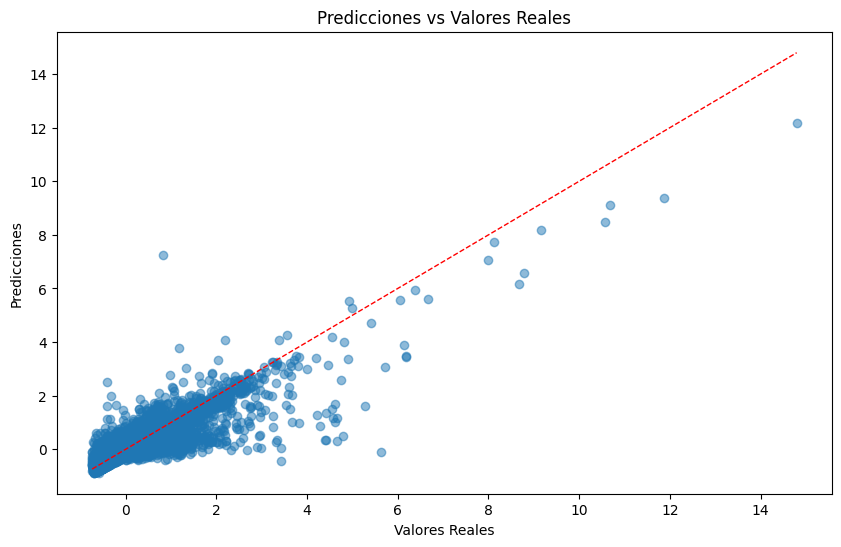

In [267]:

# Comparación de valores reales vs. predichos
# Crear un gráfico de dispersión
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_lin, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=1)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs Valores Reales')
plt.show()

###### Super Vector Machine :

In [268]:
from sklearn.svm import SVR

# Inicializar el modelo
svm_model = SVR(kernel='rbf') # Puedes experimentar con otros kernels

# Entrenar el modelo
svm_model.fit(X_train, y_train)

# Predicciones
y_pred_svm = svm_model.predict(X_test)


In [269]:
print('R^2 =',r2_score(y_test,y_pred_svm))
print('MSE =',mean_squared_error(y_test, y_pred_svm))

R^2 = 0.5599885463862144
MSE = 0.2583465774483612


In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'epsilon': [0.1, 0.2, 0.5, 0.3],
    'kernel': ['rbf']
}

grid = GridSearchCV(SVR(), param_grid, refit=True, verbose=2)
grid.fit(X_train, y_train)

# Los mejores parámetros
print("Mejores parametros:", grid.best_params_)

print('-----------------------------------------------------------------------------------')

# Usar el mejor modelo encontrado por GridSearchCV
best_svr = grid.best_estimator_

# Predecir con el conjunto de prueba
y_pred_svm = best_svr.predict(X_test)

# Calcular el R² de train
y_pred_train_svm = best_svr.predict(X_train)
r2_svm_train = r2_score(y_train, y_pred_train_svm)
print(f"R² Score: {r2_svm_train}")

print('-----------------------------------------------------------------------------------')
# Calcular el R² de test
r2_svm = r2_score(y_test, y_pred_svm)
print(f"R² Score: {r2_svm}")



###### Arbol de decision :

In [270]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree


# Inicializar el modelo
tree_model = DecisionTreeRegressor(random_state=1234)

# Entrenar el modelo
tree_model.fit(X_train, y_train)

# Predicciones
y_pred_ar = tree_model.predict(X_test)

# Evaluación del modelo
mse_ar = mean_squared_error(y_test, y_pred_ar)
rmse_ar = np.sqrt(mse)
mae_ar = mean_absolute_error(y_test, y_pred_ar)
r2_ar = r2_score(y_test, y_pred_ar)

print(f"R² Score: {r2_ar}")
print('Mean Absolute Error:', mae)
print(f"Mean Squared Error: {mse_ar}")
print('Reajusted Mean Squared Error:', rmse_ar)


#plt.figure(figsize=(12,8))
#plot_tree(tree_model, filled=True, feature_names=X.columns, rounded=True)
#plt.show()


R² Score: 0.5752238279920201
Mean Absolute Error: 0.22213916631666886
Mean Squared Error: 0.2494013947105122
Reajusted Mean Squared Error: 0.36755540623017785


<h3>Clasificación</h3>

###### Crossvalidation :

In [ ]:
from sklearn.model_selection import cross_validate, cross_val_score


scores = cross_val_score(model, X_train, y_train, cv=5)
print(scores)

cv_results = cross_validate(model, X_train, y_train, cv=5)
print(cv_results)

[0.67209448 0.69333263 0.6945432  0.56449981 0.11009665]
{'fit_time': array([0.31835318, 0.33962035, 0.31455636, 0.30623579, 0.35713601]), 'score_time': array([0.01011753, 0.00897551, 0.00881362, 0.00708961, 0.00798011]), 'test_score': array([0.67209448, 0.69333263, 0.6945432 , 0.56449981, 0.11009665])}


In [ ]:
print('El promedio es:', np.mean(scores))
print('La desviacion estandar es:', np.std(scores) )

## Apuntes

Ver train y test para el modelo para ver si estan sobreajustado. Ambos deberian ser parecidos

Para solucionar en caso de sobreajustado revisar parametros o crossvalidation(K = 5 o K = 10). No hiperparametros